## Tic-Tac-Toe Agent
---

In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. 

The following is the layout of the notebook:
    - Defining epsilon-greedy strategy
    - Tracking state-action pairs for convergence
    - Define hyperparameters for the Q-learning algorithm
    - Generating episode and applying Q-update equation
    - Checking convergence in Q-values

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [31]:
import collections
import numpy as np
import random
import pickle
import time
import os

from matplotlib import pyplot as plt
from itertools import product
from TCGame_Env import TicTacToe
from tqdm import tqdm
%matplotlib inline

### Helper Functions
---

#### convert state array into a string to be used as a key in Q - Dictionary

>  for a given state :
-  x | 4 | 5
-  3 | 8 | x
-  x | x | x
   
*generated key :* **x-4-5-3-8-x-x-x-x**

In [33]:
def generate_state_key(state):

    return ('-'.join(str(e) for e in state)).replace('nan', 'x')

#### generate valid 'agent' actions for a given state

In [34]:
def generate_valid_actions(state):
    
    possible_agent_actions, possible_env_actions = env.action_space(state)

    agent_actions_list = [ac for i, ac in enumerate(possible_agent_actions)]

    return agent_actions_list

#### add new state to Q - Dictionary

In [35]:
def add_state_to_q_dict(state):
    # convert new state into Q-dictionary key form
    new_state_key = generate_state_key(state)

    # calculate valid actions for the given state
    agent_actions = generate_valid_actions(state)

    if new_state_key not in Q_dict.keys():
        for action in agent_actions:
            Q_dict[new_state_key][action] = 0

#### tracking states initialization

In [36]:
def initialise_tracking_states():
    state_action_pair = [('x-7-3-x-2-8-x-x-x', (0, 1)),
                         ('x-1-2-x-7-x-x-6-x', (3, 3)),
                         ('x-1-x-x-x-x-8-6-7', (0, 3)),
                         ('6-x-7-x-x-1-x-x-4', (1, 5)),
                         ('x-x-x-4-9-2-7-x-x', (1, 1)),
                         ('x-x-3-8-2-x-x-x-5', (0, 1)),
                         ('3-x-7-x-x-x-x-8-2', (5, 5)),
                         ('2-x-1-8-x-7-x-x-x', (4, 3)),
                         ('1-x-3-x-6-x-x-4-x', (1, 5))] 
    for st, ac in state_action_pair:
        tracked_states[st][ac] = list()
        tracked_rewards[st] = list()

#### saving q-values corresponding to tracked states

In [37]:
def save_tracking_states():
    for state in tracked_states.keys():
        for action in tracked_states[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                tracked_states[state][action].append(Q_dict[state][action])

#### save model object

In [38]:
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Epsilon - Greedy Strategy
---

Epsilon greedy policy is a way of selecting random actions with uniform distribution from a set of available actions. Using this policy either we can select random action with epsilon probability and we can select an action with 1-epsilon probability that gives maximum reward in given state

#### check epsilon decay over episodes

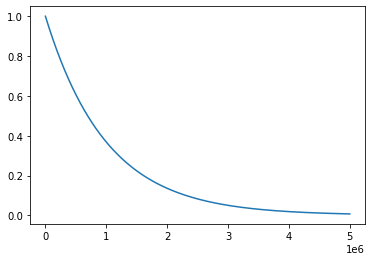

In [39]:
epsilon = []
max_epsilon = 1.0
min_epsilon = 0.001

episodes = np.arange(0, 5000000)

for i in episodes:
    epsilon.append(min_epsilon +
                   (max_epsilon - min_epsilon) * np.exp(-0.000001 * i))

plt.plot(episodes, epsilon)
plt.show()

In [40]:
def select_action_epsilon_greedy(state, episodes):

    max_epsilon = 1.0
    min_epsilon = 0.001
    
    random_value = np.random.random()
    
    # with increase in the number of episodes, epsilon value reduces
    # this pushes the system to exploit existing system states
    epsilon_value = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001 * episodes)
    
    if random_value > epsilon_value:
        # exploitation strategy - gets the action corresponding to max q-value for given state
        proposed_action = max(Q_dict[generate_state_key(state)],
                              key=Q_dict[generate_state_key(state)].get)
    else:
        # exploration strategy - randomly choose an agent action from allowed action space
        proposed_action = random.choice(
            [ac for itr, ac in enumerate(env.action_space(state)[0])])
    
    return proposed_action

### Initialization
---

In [41]:
# environment object
env = TicTacToe()

# q-dictionary used for tracking (state, action) pairs with corresponing q-values
Q_dict = collections.defaultdict(dict)

# set of states tracked for convergence
tracked_states = collections.defaultdict(dict)

# set of states tracked for rewards
tracked_rewards = collections.defaultdict(dict)

initialise_tracking_states()

### Hyperparameters
---

In [42]:
episodes = 5000000

learning_rate=0.01
gamma = 0.91

checkpoint_state_tracking = 1000
checkpoint_print_episodes = 2500000

### Q - Learning
---

In [43]:
start_time = time.time()

agent_won_count = 0
env_won_count = 0
tie_count = 0

reward_state = None

for episode in range(episodes):

    # build a new environment for this episode
#     env = TicTacToeEnvironment()

    # generate a fresh state for the current environment
    current_state = env.state

    # add current state to Q - dictionary for Q - learning
    add_state_to_q_dict(current_state)
    
    reward_state = None
    
    is_terminal_state = False
    
    # play the game till a terminal state has been reached     
    while not is_terminal_state:
        
        # use the same epsilon greedy strategy for a given episode i.e. 1 game
        agent_action = select_action_epsilon_greedy(current_state, episode)
        
        # given the current state and agent action, move game to the next step
        # record - next_state, reward, terminal state         
        next_state, reward, is_terminal_state, msg = env.step(
            current_state, agent_action)

        add_state_to_q_dict(next_state)

        current_state_key = generate_state_key(current_state)
        reward_state = current_state_key

        if is_terminal_state:
            # terminal state - either a tie or a win by agent or environment
            if msg == "Agent Won!":
                agent_won_count += 1

            elif msg == "Environment Won!":
                env_won_count += 1
                
            else:
                tie_count += 1
                
            best_next_action = None
            
            # in a terminal state, Q - value of next state will be ZERO
            Q_dict[generate_state_key(current_state)][agent_action] += learning_rate * (
                (reward +
                 (gamma * 0)) - Q_dict[generate_state_key(current_state)][agent_action])
        else:
            # generate 'best next action' corresponding to next state from Q - dictionary
            best_next_action = max(Q_dict[generate_state_key(next_state)],
                                   key=Q_dict[generate_state_key(next_state)].get)
            
            # update q-value of (current state, agent action) pair
            Q_dict[generate_state_key(current_state)][agent_action] += learning_rate * (
                (reward + (gamma *
                           (Q_dict[generate_state_key(next_state)][best_next_action]))) -
                Q_dict[generate_state_key(current_state)][agent_action])

        current_state = next_state
        
        if reward_state in tracked_rewards.keys():
            tracked_rewards[reward_state].append(reward)
#tracking the q values
    #if (episode == checkpoint_state_tracking-1):        #at the 1999th episode
        #initialise_tracking_states()

    if ((episode+1) % checkpoint_state_tracking) == 0:   #every 2000th episode
        save_tracking_states()
        save_obj(tracked_states, 'tracked_states')

    # Saving the Policy here
    
        
    if (episode + 1) % checkpoint_print_episodes == 0:
        save_obj(Q_dict,'Policy')
        print(
            "After playing %d games, Agent Won : %.4f, Environment Won : %.4f, Tie(s) : %.4f"
            % (episode + 1, agent_won_count / (episode + 1), env_won_count /
               (episode + 1), tie_count / (episode + 1)))

    

elapsed_time = time.time() - start_time
print("Elapsed time :", elapsed_time)
save_obj(tracked_states, 'tracked_states')
save_obj(Q_dict, 'Policy')

After playing 2500000 games, Agent Won : 0.4971, Environment Won : 0.1875, Tie(s) : 0.3154
After playing 5000000 games, Agent Won : 0.7138, Environment Won : 0.1058, Tie(s) : 0.1805
Elapsed time : 7415.364989042282


In [44]:
print('Number of games won by agent - {0}'.format(agent_won_count))

print('Number of games won by environment - {0}'.format(env_won_count))

print('Number of tie games - {0}'.format(tie_count))

Number of games won by agent - 3568774
Number of games won by environment - 528777
Number of tie games - 902449


### Q - values convergence
---

In [45]:
state_track_val = collections.defaultdict(dict)

for state in tracked_states.keys():
    for action in tracked_states[state].keys():
        qvals = tracked_states[state][action]
        total_tracked_values = len(qvals)
        state_track_val[state][action] = total_tracked_values
            
state_track_val

defaultdict(dict,
            {'x-7-3-x-2-8-x-x-x': {(0, 1): 4951},
             'x-1-2-x-7-x-x-6-x': {(3, 3): 4936},
             'x-1-x-x-x-x-8-6-7': {(0, 3): 4952},
             '6-x-7-x-x-1-x-x-4': {(1, 5): 4904},
             'x-x-x-4-9-2-7-x-x': {(1, 1): 4965},
             'x-x-3-8-2-x-x-x-5': {(0, 1): 4897},
             '3-x-7-x-x-x-x-8-2': {(5, 5): 4843},
             '2-x-1-8-x-7-x-x-x': {(4, 3): 4973},
             '1-x-3-x-6-x-x-4-x': {(1, 5): 4759}})

#### draw convergence plot for a state - action pair
---

In [46]:
def plot_q_val_convergence(state, action):

    iterations = state_track_val[state][action]
    plt.plot(range(0, iterations), tracked_states[state][action])
    
    
    plt.ylabel("Q_value")
    
    plt.title("State : {0} - action : {1}".format(state, action))
    plt.legend(["Q-value"], loc="lower right")

#### display convergence of tracked states
---

<Figure size 1440x1080 with 0 Axes>

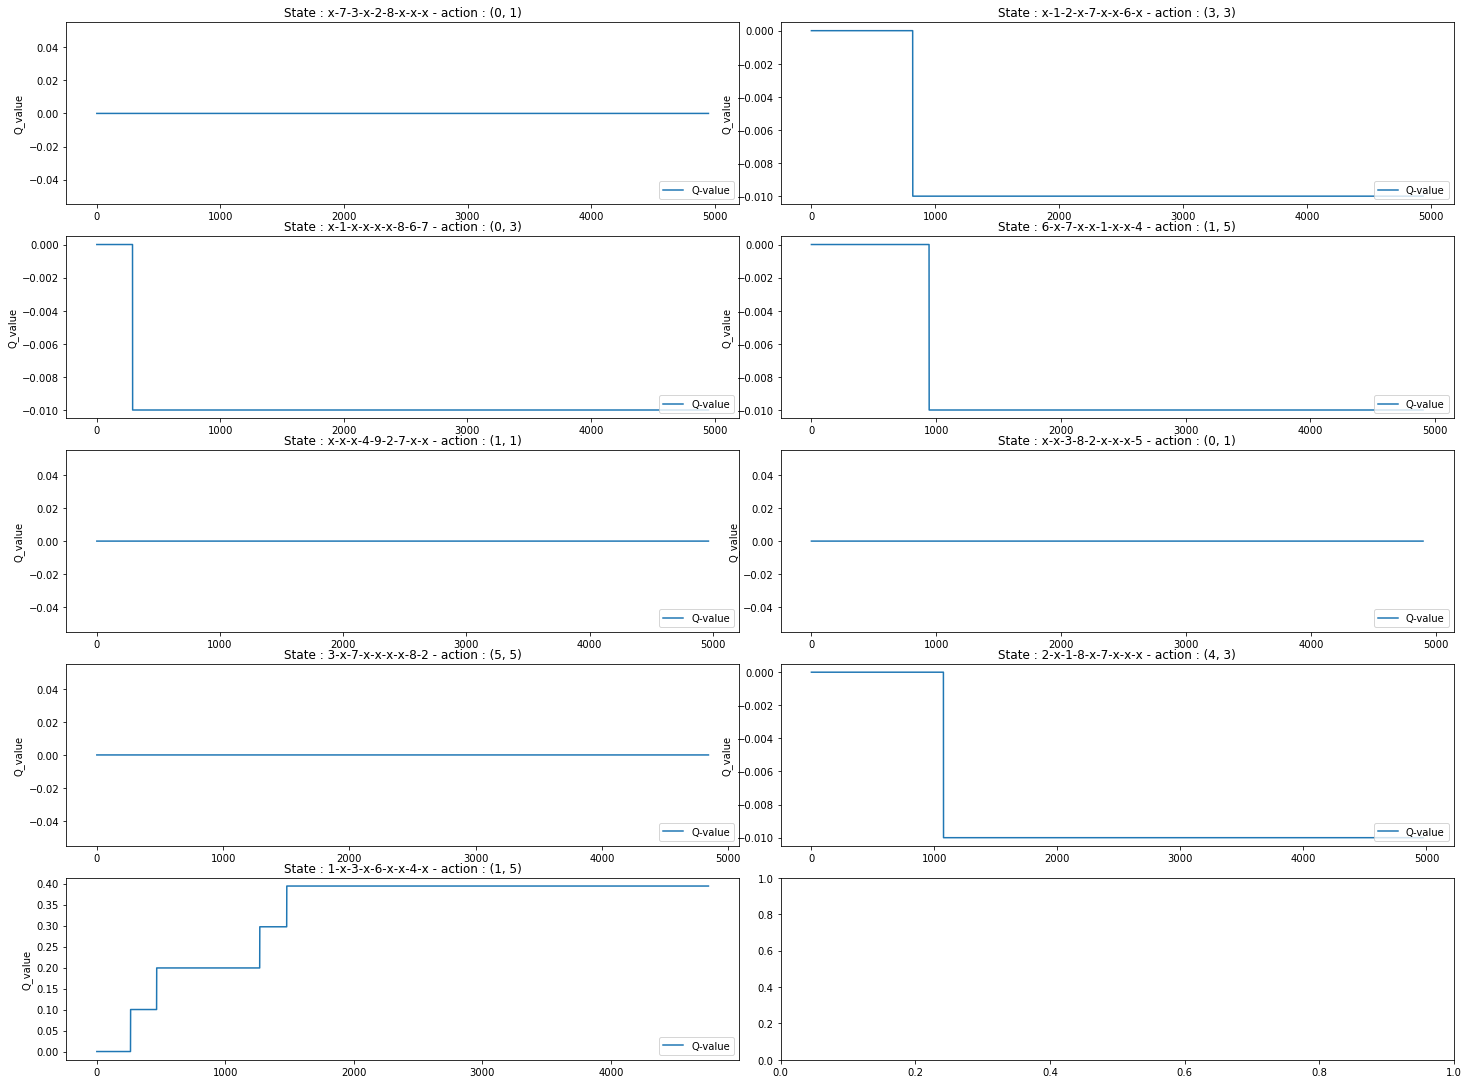

In [47]:
plt.figure(0, figsize=(20, 15))

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 15))
fig.tight_layout()

subplots = [i for i in range(521, 530)]

i = 0

for state in state_track_val.keys():
    for action in state_track_val[state].keys():
        plt.subplot(subplots[i])
        plot_q_val_convergence(state, action)
        i +=1

plt.show()

_**Following state - action pairs converged after training the system for 1 million episodes :**_

> -  state : x-7-3-x-2-8-x-x-x, action : (0, 1)
-  state : x-1-2-x-7-x-x-6-x, action : (3, 3)
-  state : x-1-x-x-x-x-8-6-7, action : (0, 3)
-  state : 6-x-7-x-x-1-x-x-4, action : (1, 5)
-  state : 1-x-3-x-6-x-x-4-x, action : (1, 5)